# 1. STRUPHY

In [3]:
import time
start_simulation = time.time()

import numpy             as np
import matplotlib.pyplot as plt
import scipy.sparse      as sparse

import utilitis_FEEC.bsplines       as bsp
import utilitis_FEEC.projectors_mhd as mhd
import utilitis_FEEC.projectors     as proj
import utilitis_FEEC.derivatives    as der
import utilitis_FEEC.evaluation     as eva

import utilitis_FEEC.mass_matrices  as mass
import utilitis_FEEC.mappings       as maps

import utilitis_PIC.ECHO_fields
import utilitis_PIC.ECHO_pusher
import utilitis_PIC.ECHO_accumulation

import sobol_seq
import scipy.special as sp

In [2]:
#====================================================================================
#  calling epyccel for particle pusher
#====================================================================================
from pyccel.epyccel import epyccel

pic_fields = epyccel(utilitis_PIC.ECHO_fields)
pic_pusher = epyccel(utilitis_PIC.ECHO_pusher)
pic_accumu = epyccel(utilitis_PIC.ECHO_accumulation)

print('pyccelization done!')
#====================================================================================

pyccelization done!


In [4]:
# ========================================== parameters ==============================================================
Nel = [3, 3, 20]           # mesh generation on logical domain
bc  = [True, True, True]   # boundary conditions
p   = [2, 2, 3]            # spline degrees  
L   = [1., 1., 2*np.pi]    # box lengthes of physical domain


el_b      = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
delta     = [1/Nel for Nel in Nel]                                             # element sizes
T         = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors
t         = [T[1:-1] for T in T]                                               # reduced knot vectors
Nbase0    = [Nel + p - bc*p for Nel, p, bc in zip(Nel, p, bc)]                 # number of basis functions in V0
Nbase_old = [Nel + p for Nel, p, bc in zip(Nel, p, bc)]                        # TODO delete this later
Ntot      =  Nbase0[0]*Nbase0[1]*Nbase0[2]                                     # total number of basis functions



dt       = 0.05     # time step
Tend     = 500.     # simulation time
max_time = 23.5*60  # maximum runtime of program in minutes

# geometry (slab geometry)
DF      = np.array([[  L[0], 0., 0.], [0.,   L[1], 0.], [0., 0.,   L[2]]])           # Jacobian matrix
DFinv   = np.array([[1/L[0], 0., 0.], [0., 1/L[1], 0.], [0., 0., 1/L[2]]])           # inverse Jacobian matrix

G       = np.array([[  L[0]**2, 0., 0.], [0.,   L[1]**2, 0.], [0., 0.,   L[2]**2]])  # metric tensor
Ginv    = np.array([[1/L[0]**2, 0., 0.], [0., 1/L[1]**2, 0.], [0., 0., 1/L[2]**2]])  # inverse metric tensor

g_sqrt  = L[0]*L[1]*L[2]                                                             # Jacobian determinant

mapping = maps.mappings(['slab', L[0], L[1], L[2]])                                  # object for mappings in MHD part


# particle parameters
Np      = int(2e5)         # total number of particles
vth     = 1.               # thermal velocity of particles in all directions

v0x     = 0.               # mean velocity of hot ions in x-direction (must be compatible with backgound field)
v0y     = 0.               # mean velocity of hot ions in y-direction (must be compatible with backgound field)
v0z     = 2.               # mean velocity of hot ions in z-direction (must be compatible with backgound field)

nuh     = 0.05             # ratio of hot/bulk equlibrium number densities 

control = 1                # control variate? (0: no, 1: yes)


# name of data file
identifier  = 'STRUPHY_Nel=32_p=3_L=2pi_dt=0.05_Np=1e5_vth=1.0_v0=2.0_nuh=0.05_k=1.0_amp=1e-4_CV=off_test'
dir_results = 'results/'
# =====================================================================================================================


# ===================== coefficients for pp-forms in interval [0, delta] (N and D) ====================================
pp0 = []
pp1 = []

for i in range(3):
    if p[i] == 3:
        pp0.append(np.asfortranarray([[1/6, -1/(2*delta[i]), 1/(2*delta[i]**2), -1/(6*delta[i]**3)], [2/3, 0., -1/delta[i]**2, 1/(2*delta[i]**3)], [1/6, 1/(2*delta[i]), 1/(2*delta[i]**2), -1/(2*delta[i]**3)], [0., 0., 0., 1/(6*delta[i]**3)]]))
        pp1.append(np.asfortranarray([[1/2, -1/delta[i], 1/(2*delta[i]**2)], [1/2, 1/delta[i], -1/delta[i]**2], [0., 0., 1/(2*delta[i]**2)]])/delta[i])
    elif p[i] == 2:
        pp0.append(np.asfortranarray([[1/2, -1/delta[i], 1/(2*delta[i]**2)], [1/2, 1/delta[i], -1/delta[i]**2], [0., 0., 1/(2*delta[i]**2)]]))
        pp1.append(np.asfortranarray([[1., -1/delta[i]], [0., 1/delta[i]]])/delta[i])
    else:
        print('So far only cubic and quadratic splines implemented!')
# =====================================================================================================================


# ====================================== background quantities ========================================================
Ueq_phys   = np.array([0., 0., 0.])     # background bulk flow (vector/1-form on physical domain)
Ueq        = DF.T.dot(Ueq_phys)         # background bulk flow (1-form on logical domain)


Beq_phys   = np.array([0., 0., 1.])     # background magnetic field (vector/2-form on physical domain)
Beq        = g_sqrt*DFinv.dot(Beq_phys) # background magnetic field (2-form on logical domain)

B0_23      = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[0][0](q1, q2, q3) * (0.)
B0_31      = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[1][1](q1, q2, q3) * (0.)   
B0_12      = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[2][2](q1, q2, q3) * (1.)   

B0_hat     = [B0_23, B0_31, B0_12]

rhoeq_phys = 1.                         # background bulk mass density (scalar/3-from on physical domain)

rho0_123   = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * (rhoeq_phys) # background bulk mass density (3-form on logical domain)
# =====================================================================================================================


# ============================================== initial conditions ===================================================
k      = 1.    # wavenumber of initial perturbation
amp    = 1e-4  # amplitude  of initial perturbation

B1_ini = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[0][0](q1, q2, q3) * (amp * np.sin(k * q3 *L[2]))
B2_ini = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[1][1](q1, q2, q3) * (0. * q1)
B3_ini = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[2][2](q1, q2, q3) * (0. * q1)

U1_ini = lambda q1, q2, q3 : mapping.DF[0][0](q1, q2, q3) * (0. * q1)  # actually DF.T !!
U2_ini = lambda q1, q2, q3 : mapping.DF[1][1](q1, q2, q3) * (0. * q1)  # actually DF.T !!
U3_ini = lambda q1, q2, q3 : mapping.DF[2][2](q1, q2, q3) * (0. * q1)  # actually DF.T !!


nh0_phys = rhoeq_phys*nuh              # hot ion number density on physical domain
nh0      = nh0_phys*g_sqrt             # hot ion number density on logical domain
Eh_eq    = nh0/2*(v0z**2 + 3*vth**2/2) # hot ion equilibrium energy

# initial hot ion distribution function (3-form on logical domain)
fh0             = lambda q1, q2, q3, vx, vy, vz : nh0/((np.pi)**(3/2)*vth**3)*np.exp(-(vx - v0x)**2/vth**2 - (vy - v0y)**2/vth**2 - (vz - v0z)**2/vth**2)

# control variate
control_variate = lambda q1, q2, q3, vx, vy, vz : nh0/((np.pi)**(3/2)*vth**3)*np.exp(-(vx - v0x)**2/vth**2 - (vy - v0y)**2/vth**2 - (vz - v0z)**2/vth**2)

# initial sampling distribution
g_sampling      = lambda q1, q2, q3, vx, vy, vz :   1/((np.pi)**(3/2)*vth**3)*np.exp(-(vx - v0x)**2/vth**2 - (vy - v0y)**2/vth**2 - (vz - v0z)**2/vth**2)
# =====================================================================================================================

In [5]:
# ========================================= reserve memory for unknowns ===============================================
b     = np.empty(3*Ntot, dtype=float)   # B-field FEM coefficients
u     = np.empty(3*Ntot, dtype=float)   # U-field FEM coefficients
u_old = np.empty(3*Ntot, dtype=float)   # U-field FEM coefficients from previous time step (needed in step 3)


# matrices and vectors in steps 1 and 3
mat11 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
mat12 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
mat13 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')

mat22 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
mat23 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
mat33 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')

vec1  = np.empty((Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
vec2  = np.empty((Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
vec3  = np.empty((Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')

# particles and span indices
particles = np.empty((Np, 7), dtype=float, order='F')
spans0    = np.empty((Np, 3), dtype=int,   order='F')

# fields at particle positions
B_part = np.empty((Np, 3), dtype=float, order='F')
U_part = np.empty((Np, 3), dtype=float, order='F')

# energies
energies = np.empty(3, dtype=float)
# =====================================================================================================================

projection of initial conditions done


Text(0,0.5,'Uz')

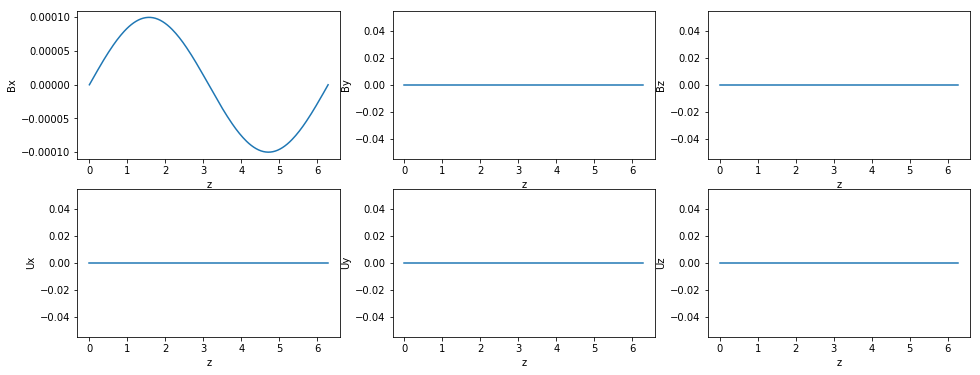

In [6]:
# ======================================== projection of initial conditions ===========================================
# create object for projecting initial conditions
PRO = proj.projectors_3d(p, Nbase_old, T, bc)

# left-hand sides of projectors
PRO.assemble_V1()
PRO.assemble_V2()

# projection of initial conditions
b[0*Ntot:1*Ntot], b[1*Ntot:2*Ntot], b[2*Ntot:3*Ntot] = PRO.PI_2([B1_ini, B2_ini, B3_ini])
u[0*Ntot:1*Ntot], u[1*Ntot:2*Ntot], u[2*Ntot:3*Ntot] = PRO.PI_1([U1_ini, U2_ini, U3_ini])


print('projection of initial conditions done')
# =====================================================================================================================


# plot initial conditions on physical domain
q1plot = np.array([0.5])
q2plot = np.array([0.5])
q3plot = np.linspace(0., 1., 200)

Bini1, Bini2, Bini3 = eva.FEM_field_V2_3d([b[0*Ntot:1*Ntot], b[1*Ntot:2*Ntot], b[2*Ntot:3*Ntot]], [q1plot, q2plot, q3plot], T, p, bc)
Uini1, Uini2, Uini3 = eva.FEM_field_V1_3d([u[0*Ntot:1*Ntot], u[1*Ntot:2*Ntot], u[2*Ntot:3*Ntot]], [q1plot, q2plot, q3plot], T, p, bc)

fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(6)

plt.subplot(2, 3, 1)
plt.plot(q3plot*L[2], 1/g_sqrt*DF[0, 0]*Bini1)
plt.xlabel('z')
plt.ylabel('Bx')

plt.subplot(2, 3, 2)
plt.plot(q3plot*L[2], 1/g_sqrt*DF[1, 1]*Bini2)
plt.xlabel('z')
plt.ylabel('By')

plt.subplot(2, 3, 3)
plt.plot(q3plot*L[2], 1/g_sqrt*DF[2, 2]*Bini3)
plt.xlabel('z')
plt.ylabel('Bz')

plt.subplot(2, 3, 4)
plt.plot(q3plot*L[2], DFinv[0, 0]*Uini1)
plt.xlabel('z')
plt.ylabel('Ux')

plt.subplot(2, 3, 5)
plt.plot(q3plot*L[2], DFinv[1, 1]*Uini2)
plt.xlabel('z')
plt.ylabel('Uy')

plt.subplot(2, 3, 6)
plt.plot(q3plot*L[2], DFinv[2, 2]*Uini3)
plt.xlabel('z')
plt.ylabel('Uz')

In [8]:
# ============================================ MHD matrices ===========================================================
# create object for projecting MHD matrices
MHD = mhd.projections_mhd(p, Nbase_old, T, bc)

# right-hand side of projection matrices
W1,   W2,   W3   = MHD.projection_W(rho0_123, mapping.g_sqrt)
TAU1, TAU2, TAU3 = MHD.projection_T(B0_hat, mapping.Ginv)

# mass matrices in V1 and V2
M1 = mass.mass_V1(T, p, bc, mapping.Ginv, mapping.g_sqrt)
M2 = mass.mass_V2(T, p, bc, mapping.G, mapping.g_sqrt)

# discrete curl and div matrices
derivatives = der.discrete_derivatives(T, p, bc)

CURL = derivatives.CURL_3d()
DIV  = derivatives.DIV_3d()

# perform projections of TAU1, TAU2, TAU3
TAU1 = sparse.linalg.spsolve(PRO.interhistopolation_V1_1, TAU1)
TAU2 = sparse.linalg.spsolve(PRO.interhistopolation_V1_2, TAU2)
TAU3 = sparse.linalg.spsolve(PRO.interhistopolation_V1_3, TAU3)

TAU  = sparse.bmat([[TAU1], [TAU2], [TAU3]], format='csc')

# perform projections of W1, W2, W3
W1   = sparse.linalg.spsolve(PRO.interhistopolation_V1_1, W1)
W2   = sparse.linalg.spsolve(PRO.interhistopolation_V1_2, W2)
W3   = sparse.linalg.spsolve(PRO.interhistopolation_V1_3, W3)

W    = sparse.bmat([[W1, None, None], [None, W2, None], [None, None, W3]], format='csc')

# compute matrix A
A = 1/2*(M1.dot(W) + W.T.dot(M1))


# LU decompostion of Schur complement in step 2
STEP2_schur_LU = sparse.linalg.splu((A + dt**2/4*TAU.T.dot(CURL.T.dot(M2.dot(CURL.dot(TAU))))).tocsc())

# other matrices needed in step2
STEP2_1 = (A - dt**2/4*TAU.T.dot(CURL.T.dot(M2.dot(CURL.dot(TAU))))).tocsc()
STEP2_2 = dt*TAU.T.dot(CURL.T.dot(M2)).tocsc()

A = A.toarray()

# delete everything which is not needed to save memory
#del PRO, MHD, W1, W2, W3, TAU1, TAU2, TAU3, M1, W

print('assembly of constant matrices done')
# ======================================================================================================================

assembly of constant matrices done


Text(0,0.5,'$n_{h0}(U x B)_z$')

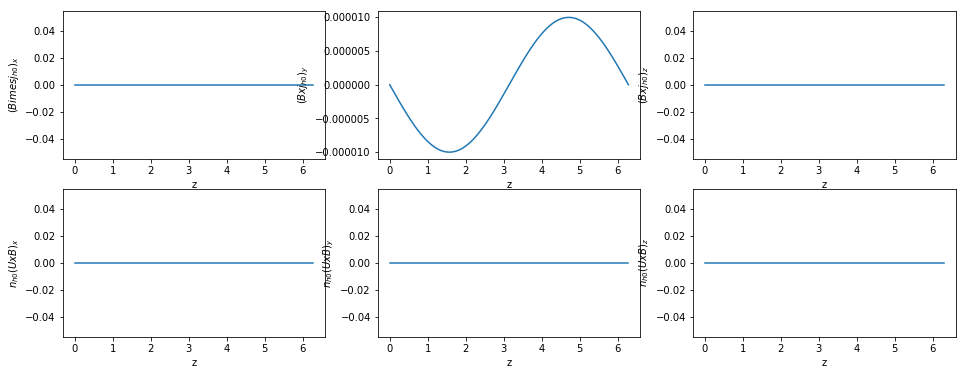

In [10]:
# check initial control variates
J14_control       = mass.inner_prod_V1_jh0(T, p, bc, mapping.Ginv, mapping.DFinv, mapping.g_sqrt, b[0*Ntot:1*Ntot], b[1*Ntot:2*Ntot], b[2*Ntot:3*Ntot], Beq, [nuh*v0x, nuh*v0y, nuh*v0z])
J11_control       = mass.mass_V1_nh0(T, p, bc, mapping.Ginv, b[0*Ntot:1*Ntot], b[1*Ntot:2*Ntot], b[2*Ntot:3*Ntot], Beq, nh0)

J14_control_coeff = sparse.linalg.spsolve(M1, np.concatenate((J14_control[0].flatten(), J14_control[1].flatten(), J14_control[2].flatten())))
J11_control_coeff = sparse.linalg.spsolve(M1, -J11_control.dot(u))


J14_control_1, J14_control_2, J14_control_3 = eva.FEM_field_V1_3d([J14_control_coeff[0*Ntot:1*Ntot], J14_control_coeff[1*Ntot:2*Ntot], J14_control_coeff[2*Ntot:3*Ntot]], [q1plot, q2plot, q3plot], T, p, bc)
J11_control_1, J11_control_2, J11_control_3 = eva.FEM_field_V1_3d([J11_control_coeff[0*Ntot:1*Ntot], J11_control_coeff[1*Ntot:2*Ntot], J11_control_coeff[2*Ntot:3*Ntot]], [q1plot, q2plot, q3plot], T, p, bc)

fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(6)

plt.subplot(2, 3, 1)
plt.plot(q3plot*L[2], DFinv[0, 0]*J14_control_1)
plt.xlabel('z')
plt.ylabel('$(B \times j_{h0})_x$')

plt.subplot(2, 3, 2)
plt.plot(q3plot*L[2], DFinv[1, 1]*J14_control_2)
plt.xlabel('z')
plt.ylabel('$(Bx j_{h0})_y$')

plt.subplot(2, 3, 3)
plt.plot(q3plot*L[2], DFinv[2, 2]*J14_control_3)
plt.xlabel('z')
plt.ylabel('$(Bx j_{h0})_z$')

plt.subplot(2, 3, 4)
plt.plot(q3plot*L[2], DFinv[0, 0]*J11_control_1)
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_x$')

plt.subplot(2, 3, 5)
plt.plot(q3plot*L[2], DFinv[1, 1]*J11_control_2)
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_y$')

plt.subplot(2, 3, 6)
plt.plot(q3plot*L[2], DFinv[2, 2]*J11_control_3)
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_z$')

In [11]:
# ================================================ create particles ====================================================
#particles[:, :6] = sobol_seq.i4_sobol_generate(6, Np)   # quasi-random Sobol numbers between (0, 1)
particles[:, :6] = np.random.rand(Np, 6)                 # random numbers between (0, 1)
#particles[:, :] = np.load('test_particles.npy')         # load numbers from file

# inversion of cumulative distribution function
particles[:, 3]  = sp.erfinv(2*particles[:, 3] - 1)*vth + v0x
particles[:, 4]  = sp.erfinv(2*particles[:, 4] - 1)*vth + v0y
particles[:, 5]  = sp.erfinv(2*particles[:, 5] - 1)*vth + v0z

# compute parameters for control variate and initial weights
g0 = g_sampling(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3], particles[:, 4], particles[:, 5])
w0 = fh0(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3], particles[:, 4], particles[:, 5])/g0

particles[:, 6] = w0 - control*control_variate(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3], particles[:, 4], particles[:, 5])/g0 

# compute initial knot span indices
spans0[:, 0] = np.floor(particles[:, 0]*Nel[0]).astype(int) + p[0]
spans0[:, 1] = np.floor(particles[:, 1]*Nel[1]).astype(int) + p[1]
spans0[:, 2] = np.floor(particles[:, 2]*Nel[2]).astype(int) + p[2]

print('particle initialization done')
# =====================================================================================================================

particle initialization done


(array([4.0000e+00, 1.3000e+01, 5.0000e+01, 1.4100e+02, 3.3100e+02,
        7.3800e+02, 1.5060e+03, 2.8740e+03, 4.9780e+03, 8.0510e+03,
        1.1748e+04, 1.5637e+04, 1.9390e+04, 2.2429e+04, 2.3458e+04,
        2.2337e+04, 1.9733e+04, 1.5808e+04, 1.1921e+04, 8.1030e+03,
        4.9700e+03, 2.8690e+03, 1.5650e+03, 7.9000e+02, 3.3600e+02,
        1.3700e+02, 5.6000e+01, 1.6000e+01, 4.0000e+00]),
 array([-1.        , -0.79310345, -0.5862069 , -0.37931034, -0.17241379,
         0.03448276,  0.24137931,  0.44827586,  0.65517241,  0.86206897,
         1.06896552,  1.27586207,  1.48275862,  1.68965517,  1.89655172,
         2.10344828,  2.31034483,  2.51724138,  2.72413793,  2.93103448,
         3.13793103,  3.34482759,  3.55172414,  3.75862069,  3.96551724,
         4.17241379,  4.37931034,  4.5862069 ,  4.79310345,  5.        ]),
 <a list of 29 Patch objects>)

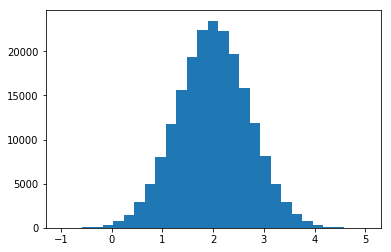

In [12]:
plt.hist(particles[:, 5], bins = np.linspace(-3., 3., 30) + v0z)

In [13]:
# ================ compute initial fields at particle positions and initial energies ==================================
timea = time.time()
pic_fields.evaluate_2form(particles[:, 0:3], p, spans0, Nbase0, Np, np.asfortranarray(b[:Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[Ntot:2*Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[2*Ntot:].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), Beq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part)
pic_fields.evaluate_1form(particles[:, 0:3], p, spans0, Nbase0, Np, np.asfortranarray(u[:Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(u[Ntot:2*Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(u[2*Ntot:].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), Ueq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], U_part)
timeb = time.time()
print('initial field computation at particles done. Time : ', timeb-timea)


# initial energies
energies[0] = 1/2*u.dot(A.dot(u))
energies[1] = 1/2*b.dot(M2.dot(b))
energies[2] = 1/2*particles[:, 6].dot(particles[:, 3]**2 + particles[:, 4]**2 + particles[:, 5]**2)/Np + (control - 1)*Eh_eq
# =====================================================================================================================

initial field computation at particles done. Time :  4.093585252761841


In [15]:
# =============================================== time integrator =====================================================
def update():
    
    # step 1 (update u)
    pic_accumu.accumulation_step1(particles, p, spans0, Nbase0, T[0], T[1], T[2], t[0], t[1], t[2], L, B_part, mat12, mat13, mat23)
    
    AJ11A = -np.block([[np.zeros((Ntot, Ntot)), mat12.reshape(Ntot, Ntot), mat13.reshape(Ntot, Ntot)], [-mat12.reshape(Ntot, Ntot).T, np.zeros((Ntot, Ntot)), mat23.reshape(Ntot, Ntot)], [-mat13.reshape(Ntot, Ntot).T, -mat23.reshape(Ntot, Ntot).T, np.zeros((Ntot, Ntot))]])/Np
    
    if control == 1:
        AJ11A -= mass.mass_V1_nh0(T, p, bc, mapping.Ginv, b[0*Ntot:1*Ntot], b[1*Ntot:2*Ntot], b[2*Ntot:3*Ntot], Beq, nh0).toarray()
    
    u[:] = np.linalg.solve(A - dt/2*AJ11A, (A + dt/2*AJ11A).dot(u))
    
    
    # step 2 (update first u, then b and evaluate B-field at particle positions)
    u_old[:] = u
    
    u[:] = STEP2_schur_LU.solve(STEP2_1.dot(u_old) + STEP2_2.dot(b))
    b[:] = b - dt/2*CURL.dot(TAU.dot(u_old + u))
    
    pic_fields.evaluate_2form(particles[:, 0:3], p, spans0, Nbase0, Np, np.asfortranarray(b[:Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[Ntot:2*Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[2*Ntot:].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), Beq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part)
    
    
    # step 3 (update first u, then evaluate U-field at particle positions and then update V)
    pic_accumu.accumulation_step3(particles, p, spans0, Nbase0, T[0], T[1], T[2], t[0], t[1], t[2], L, B_part, mat11, mat12, mat13, mat22, mat23, mat33, vec1, vec2, vec3)
    
    BLOCK = np.block([[mat11.reshape(Ntot, Ntot), mat12.reshape(Ntot, Ntot), mat13.reshape(Ntot, Ntot)], [mat12.reshape(Ntot, Ntot).T, mat22.reshape(Ntot, Ntot), mat23.reshape(Ntot, Ntot)], [mat13.reshape(Ntot, Ntot).T, mat23.reshape(Ntot, Ntot).T, mat33.reshape(Ntot, Ntot)]])/Np
    
    u_old[:] = u
    
    if control == 1:
        CV = mass.inner_prod_V1_jh0(T, p, bc, mapping.Ginv, mapping.DFinv, mapping.g_sqrt, b[0*Ntot:1*Ntot], b[1*Ntot:2*Ntot], b[2*Ntot:3*Ntot], Beq, [nh0_phys*v0x, nh0_phys*v0y, nh0_phys*v0z])
        
        u[:] = np.linalg.solve(A + dt**2/4*BLOCK, (A - dt**2/4*BLOCK).dot(u_old) + dt*np.concatenate((vec1.flatten(), vec2.flatten(), vec3.flatten()))/Np + dt*np.concatenate((CV[0].flatten(), CV[1].flatten(), CV[2].flatten())))
    
    
    else:
        u[:] = np.linalg.solve(A + dt**2/4*BLOCK, (A - dt**2/4*BLOCK).dot(u_old) + dt*np.concatenate((vec1.flatten(), vec2.flatten(), vec3.flatten()))/Np)
    
    
    pic_fields.evaluate_1form(particles[:, 0:3], p, spans0, Nbase0, Np, np.asfortranarray(1/2*(u + u_old)[:Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(1/2*(u + u_old)[Ntot:2*Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(1/2*(u + u_old)[2*Ntot:].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), Ueq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], U_part)
    
    pic_pusher.pusher_step3(particles, L, dt, B_part, U_part)
    
    # step 4 (update Q and spans)
    pic_pusher.pusher_step4(particles, L, dt)
    
    spans0[:, 0] = np.floor(particles[:, 0]*Nel[0]).astype(int) + p[0]
    spans0[:, 1] = np.floor(particles[:, 1]*Nel[1]).astype(int) + p[1]
    spans0[:, 2] = np.floor(particles[:, 2]*Nel[2]).astype(int) + p[2]
    
    # step 5 (update V and weights)
    pic_fields.evaluate_2form(particles[:, 0:3], p, spans0, Nbase0, Np, np.asfortranarray(b[:Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[Ntot:2*Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[2*Ntot:].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), Beq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part)
    pic_pusher.pusher_step5(particles, L, dt, B_part)
    
    particles[:, 6] = w0 - control*control_variate(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3], particles[:, 4], particles[:, 5])/g0 
    
    # diagnostics
    energies[0] = 1/2*u.dot(A.dot(u))
    energies[1] = 1/2*b.dot(M2.dot(b))
    energies[2] = 1/2*particles[:, 6].dot(particles[:, 3]**2 + particles[:, 4]**2 + particles[:, 5]**2)/Np + (control - 1)*Eh_eq
# =====================================================================================================================    

In [16]:
# ========================================== time integration =========================================================
title = dir_results + identifier + '.txt'
file  = open(title, 'ab')
data  = np.concatenate((energies, np.array([0.])))
np.savetxt(file, data.reshape(1, 4), fmt = '%1.16e')

print('initial energies:', energies)
print('start time integration! (number of time steps : ' + str(int(Tend/dt)) + ')')
time_step = 0

while True:
    
    if (time_step*dt >= Tend) or ((time.time() - start_simulation)/60 > max_time):
        break
        
    if time_step%5 == 0:
        print('time steps finished: ' + str(time_step))
        print('energies', energies)
    
    update()
    
    data  = np.concatenate((energies, np.array([(time_step + 1)*dt])))
    np.savetxt(file, data.reshape(1, 4), fmt = '%1.16e')
    
    time_step += 1
    
file.close()
# =====================================================================================================================

initial energies: [0.00000000e+00 1.57075287e-08 0.00000000e+00]
start time integration! (number of time steps : 10000)
time steps finished: 0
energies [0.00000000e+00 1.57075287e-08 0.00000000e+00]
time steps finished: 5
energies [9.71248449e-10 1.47465532e-08 1.96882234e-07]
time steps finished: 10
energies [3.66548498e-09 1.20968097e-08 3.12199646e-07]


KeyboardInterrupt: 

In [17]:
file.close()

# 2. Development

In [58]:
# step 3 (update first u, then evaluate U-field at particle positions and then update V, then update weights and iterate)
counter = 0

CV = mass.inner_prod_V1_jh0(T, p, bc, mapping.Ginv, mapping.DFinv, mapping.g_sqrt, b[0*Ntot:1*Ntot], b[1*Ntot:2*Ntot], b[2*Ntot:3*Ntot], Beq, [0., 0., nuh*v0])

while True:
    print(counter)
    
    u_old[:] = u
    pic_fields.evaluate_1form(particles[:, 0:3], p, spans0, Nbase0, Np, np.asfortranarray(1/2*(u + u_old)[:Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(1/2*(u + u_old)[Ntot:2*Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(1/2*(u + u_old)[2*Ntot:].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), Ueq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], U_part)
    pic_pusher.pusher_step3(particles, L, dt, B_part, U_part)
    particles[:, 6]  = w0 - control*control_variate(particles[:, 3], particles[:, 4], particles[:, 5])/g0
    
    pic_accumu.accumulation_step3(particles, p, spans0, Nbase0, T[0], T[1], T[2], t[0], t[1], t[2], L, B_part, mat11, mat12, mat13, mat22, mat23, mat33, vec1, vec2, vec3)
    BLOCK = np.block([[mat11.reshape(Ntot, Ntot), mat12.reshape(Ntot, Ntot), mat13.reshape(Ntot, Ntot)], [mat12.reshape(Ntot, Ntot).T, mat22.reshape(Ntot, Ntot), mat23.reshape(Ntot, Ntot)], [mat13.reshape(Ntot, Ntot).T, mat23.reshape(Ntot, Ntot).T, mat33.reshape(Ntot, Ntot)]])/Np
    u[:] = np.linalg.solve(A + dt**2/4*BLOCK, (A - dt**2/4*BLOCK).dot(u_old) + dt*np.concatenate((vec1.flatten(), vec2.flatten(), vec3.flatten()))/Np + dt*np.concatenate((CV[0].flatten(), CV[1].flatten(), CV[2].flatten())))
    print(sum(np.abs(u_old - u)))
    
    if np.all(np.abs(u_old - u) < 1e-10):
        break
        
    counter += 1

0
3.0754626744169046e-05
1
3.0751164358251324e-05
2
3.074423997446862e-05
3
3.073385436887194e-05
4
3.072000870543751e-05
5
3.0702704535928985e-05
6
3.068194379972511e-05
7
3.065772882360985e-05
8
3.0630062321504975e-05
9
3.059894739417503e-05
10
3.056438752887509e-05
11
3.0526386598968854e-05
12
3.048494886349306e-05
13
3.0440078966685614e-05
14
3.0391781937464876e-05
15
3.034006318887453e-05
16
3.02849285174762e-05
17
3.022638410270793e-05
18
3.016443650619131e-05
19
3.0099092671005263e-05
20
3.0030359920907608e-05
21
2.995824595952811e-05
22
2.9882758869497782e-05
23
2.9803907111560097e-05
24


KeyboardInterrupt: 

In [46]:
np.all(np.abs(u_old - u) < 1e-10)

True

In [48]:
u

array([-4.17761211e-10,  4.82997184e-10, -1.65504471e-09,  1.93069956e-09,
        1.19715605e-09,  1.58635313e-09, -4.62421116e-10,  6.77542464e-10,
        1.04744754e-09, -1.62463731e-10,  1.28809035e-09,  2.83364146e-09,
        9.77969530e-10, -2.73924360e-09,  1.09037527e-09,  5.49120093e-10,
       -5.07090060e-10, -3.45895991e-14,  6.19416977e-10, -2.51510215e-09,
        2.54276732e-10,  3.15704336e-09, -1.47187804e-09, -1.30595405e-09,
       -7.53463115e-10,  4.21382562e-09,  9.15572866e-10, -1.55092546e-09,
        1.52223859e-09, -1.88488833e-09,  5.99919493e-10,  2.18682460e-11,
       -2.47625999e-10,  6.23854895e-11, -3.85507257e-10,  7.89642770e-10,
       -2.88317703e-09,  3.38081115e-10, -1.65925552e-09,  6.09924353e-09,
       -2.06607502e-09,  2.45233451e-09,  2.29319330e-09, -1.53102698e-09,
        1.51539416e-09, -9.50923475e-10,  2.12068833e-09, -4.83086835e-11,
        6.38653779e-10, -5.13934430e-10, -5.53240820e-10,  1.85499956e-09,
       -1.66531930e-09, -

In [22]:
Nt = 8000

for n in range(Nt):
    
    update()
    
    # compute energies
    en_U = 1/2*u.dot(A.dot(u))
    en_B = 1/2*b.dot(M2.dot(b))
    en_H = 1/2*particles[:, 6].dot(particles[:, 3]**2 + particles[:, 4]**2 + particles[:, 5]**2)
    
    energies = np.vstack((energies, np.array([en_U, en_B, en_H])))
    
    #if n%10 == 0:
     #   print('time step : ', n)
      #  print(energies[n + 1], en_U + en_B + en_H)
    
    print('time step : ', n)
    print(energies[n + 1], en_U + en_B + en_H)

time step :  0
[3.96123178e-11 1.56686046e-08 0.00000000e+00] 1.5708216890121348e-08
time step :  1
[1.58029435e-10 1.55513357e-08 6.25196373e-03] 0.006251979443946886
time step :  2
[3.54107429e-10 1.53572061e-08 1.21503243e-02] 0.012150340021080331
time step :  3
[6.26023613e-10 1.50881498e-08 1.76232791e-02] 0.017623294770796633
time step :  4
[9.71286493e-10 1.47468294e-08 2.26227127e-02] 0.02262272841978285
time step :  5
[1.38674789e-09 1.43366129e-08 2.71490915e-02] 0.027149107222917537
time step :  6
[1.86861789e-09 1.38615444e-08 3.12013020e-02] 0.031201317682112067
time step :  7
[2.41248352e-09 1.33263088e-08 3.48434083e-02] 0.03484342399460505
time step :  8
[3.01333243e-09 1.27361916e-08 3.81070033e-02] 0.038107019040704196
time step :  9
[3.66558216e-09 1.20970318e-08 4.10576083e-02] 0.041057624106723666
time step :  10
[4.36311592e-09 1.14151708e-08 4.37120039e-02] 0.043712019665809926
time step :  11
[5.09932545e-09 1.06973945e-08 4.61206758e-02] 0.04612069160069154
tim

time step :  98
[1.50608299e-08 2.54016196e-09 2.88704464e-02] 0.028870463996966494
time step :  99
[1.45323057e-08 3.04897104e-09 2.66593934e-02] 0.02665941100419077
time step :  100
[1.39449496e-08 3.61456137e-09 2.41433171e-02] 0.02414333461215314
time step :  101
[1.33052878e-08 4.23094077e-09 2.14429889e-02] 0.02144300639746561
time step :  102
[1.26204020e-08 4.89159213e-09 1.87053074e-02] 0.018705324877355507
time step :  103
[1.18978455e-08 5.58954448e-09 1.60593672e-02] 0.016059384716703755
time step :  104
[1.11455639e-08 6.31744875e-09 1.36046947e-02] 0.013604712149038356
time step :  105
[1.03718088e-08 7.06765671e-09 1.13501448e-02] 0.011350162266351438
time step :  106
[9.58504762e-09 7.83230492e-09 9.28914172e-03] 0.009289159137180805
time step :  107
[8.79387065e-09 8.60339758e-09 7.33268627e-03] 0.0073327036677545724
time step :  108
[8.00690002e-09 9.37289293e-09 5.34688393e-03] 0.005346901307734559
time step :  109
[7.23269603e-09 1.01327881e-08 3.11442314e-03] 0.003

time step :  192
[ 7.03879156e-09  1.33439509e-08 -4.45282167e-02] -0.04452819635557176
time step :  193
[ 7.63506120e-09  1.28645772e-08 -4.15987438e-02] -0.04159872325931638
time step :  194
[ 8.25627811e-09  1.23584279e-08 -3.96996148e-02] -0.039699594210477085
time step :  195
[ 8.89549886e-09  1.18315452e-08 -3.87983011e-02] -0.03879828041189232
time step :  196
[ 9.54562346e-09  1.12901452e-08 -3.89473937e-02] -0.03894737288230931
time step :  197
[ 1.01994665e-08  1.07405557e-08 -4.00874585e-02] -0.04008743757967248
time step :  198
[ 1.08498457e-08  1.01891457e-08 -4.21414905e-02] -0.04214146943684654
time step :  199
[ 1.14896667e-08  9.64224879e-09 -4.49985363e-02] -0.04499851521744666
time step :  200
[ 1.21120064e-08  9.10609231e-09 -4.85289106e-02] -0.04852888934620719
time step :  201
[ 1.27101803e-08  8.58673095e-09 -5.24709777e-02] -0.05247095642543612
time step :  202
[ 1.32778069e-08  8.08999118e-09 -5.67431810e-02] -0.056743159607868146
time step :  203
[ 1.38088909e

time step :  288
[1.03347862e-08 1.31119542e-08 1.59670441e-01] 0.1596704647628775
time step :  289
[1.00185095e-08 1.33997333e-08 1.64917934e-01] 0.16491795764221176
time step :  290
[9.73534274e-09 1.36642890e-08 1.70830914e-01] 0.17083093715706457
time step :  291
[9.48926035e-09 1.39024901e-08 1.77517494e-01] 0.17751751788260578
time step :  292
[9.28377471e-09 1.41115700e-08 1.85039689e-01] 0.18503971217779788
time step :  293
[9.12185038e-09 1.42891779e-08 1.93381420e-01] 0.19338144291285506
time step :  294
[9.00588986e-09 1.44333982e-08 2.02496631e-01] 0.20249665429767413
time step :  295
[8.93771963e-09 1.45427547e-08 2.12351893e-01] 0.21235191646154322
time step :  296
[8.91854036e-09 1.46162417e-08 2.22798305e-01] 0.22279832832515353
time step :  297
[8.94890313e-09 1.46533539e-08 2.33607661e-01] 0.23360768475110033
time step :  298
[9.02871907e-09 1.46540879e-08 2.44663267e-01] 0.24466329076142773
time step :  299
[9.15724887e-09 1.46189368e-08 2.55700604e-01] 0.25570062784

time step :  387
[1.93651110e-08 1.24359040e-08 2.04289087e-01] 0.2042891188798337
time step :  388
[1.88829466e-08 1.29605319e-08 1.97408600e-01] 0.19740863190038133
time step :  389
[1.83527877e-08 1.35189209e-08 1.90232231e-01] 0.19023226311015123
time step :  390
[1.77807130e-08 1.41054519e-08 1.83166410e-01] 0.18316644184070355
time step :  391
[1.71734304e-08 1.47140693e-08 1.76346547e-01] 0.176346578457818
time step :  392
[1.65381882e-08 1.53383500e-08 1.70111996e-01] 0.17011202813617984
time step :  393
[1.58826099e-08 1.59716069e-08 1.64690583e-01] 0.16469061477727057
time step :  394
[1.52146413e-08 1.66069447e-08 1.60242858e-01] 0.16024288970631345
time step :  395
[1.45424948e-08 1.72373176e-08 1.56967127e-01] 0.15696715858879703
time step :  396
[1.38745634e-08 1.78556190e-08 1.55027418e-01] 0.1550274492600532
time step :  397
[1.32193143e-08 1.84547794e-08 1.54248533e-01] 0.15424856514993612
time step :  398
[1.25851152e-08 1.90278745e-08 1.54626632e-01] 0.15462666330820

time step :  484
[ 2.21834430e-08  1.63658623e-08 -1.11122714e-01] -0.11112267568990727
time step :  485
[ 2.34422515e-08  1.53474113e-08 -1.08162872e-01] -0.10816283310623713
time step :  486
[ 2.46760735e-08  1.43621421e-08 -1.04192437e-01] -0.10419239836526453
time step :  487
[ 2.58716293e-08  1.34218028e-08 -9.94263198e-02] -0.09942628050344426
time step :  488
[ 2.70159359e-08  1.25377904e-08 -9.41455778e-02] -0.09414553822557466
time step :  489
[ 2.80964720e-08  1.17209809e-08 -8.87577508e-02] -0.08875771094699804
time step :  490
[ 2.91013717e-08  1.09816042e-08 -8.36530692e-02] -0.08365302912623156
time step :  491
[ 3.00195137e-08  1.03290979e-08 -7.91835460e-02] -0.07918350567103424
time step :  492
[ 3.08406079e-08  9.77203436e-09 -7.55065707e-02] -0.07550653010101067
time step :  493
[ 3.15553251e-08  9.31806506e-09 -7.28018432e-02] -0.07280180228233982
time step :  494
[ 3.21554036e-08  8.97379581e-09 -7.11609995e-02] -0.07116095834261812
time step :  495
[ 3.26338035e-0

time step :  580
[1.51727133e-08 3.69145067e-08 8.81436722e-02] 0.08814372430645483
time step :  581
[1.40504800e-08 3.80534810e-08 8.99720006e-02] 0.08997205269707081
time step :  582
[1.30616837e-08 3.90656113e-08 9.19533999e-02] 0.09195345199338222
time step :  583
[1.22188533e-08 3.99400803e-08 9.42133274e-02] 0.09421337960643933
time step :  584
[1.15329149e-08 4.06675550e-08 9.71052190e-02] 0.09710527123575557
time step :  585
[1.10130871e-08 4.12402957e-08 1.01039148e-01] 0.10103920018247631
time step :  586
[1.06668196e-08 4.16522269e-08 1.06356260e-01] 0.1063563120580584
time step :  587
[1.04997477e-08 4.18989842e-08 1.13191490e-01] 0.11319154282365122
time step :  588
[1.05154842e-08 4.19779933e-08 1.21881164e-01] 0.12188121618241035
time step :  589
[1.07156925e-08 4.18884987e-08 1.32895555e-01] 0.13289560744123552
time step :  590
[1.10999556e-08 4.16315962e-08 1.46260135e-01] 0.14626018823062473
time step :  591
[1.16658223e-08 4.12102331e-08 1.61936752e-01] 0.16193680439

time step :  678
[5.62851177e-08 1.75427003e-08 5.86299258e-02] 0.058629999642762075
time step :  679
[5.63003156e-08 1.77817034e-08 5.95795246e-02] 0.05957959868087704
time step :  680
[5.61029782e-08 1.82149665e-08 5.98550534e-02] 0.05985512770875597
time step :  681
[5.56963247e-08 1.88393358e-08 5.95220867e-02] 0.05952216123381017
time step :  682
[5.50858684e-08 1.96495150e-08 5.87985325e-02] 0.058798607279002886
time step :  683
[5.42793946e-08 2.06381486e-08 5.74340670e-02] 0.05743414189323499
time step :  684
[5.32869016e-08 2.17959561e-08 5.56560308e-02] 0.055656105845251755
time step :  685
[5.21203876e-08 2.31118014e-08 5.34682222e-02] 0.05346829747122804
time step :  686
[5.07939311e-08 2.45727298e-08 5.09409139e-02] 0.050940989292259584
time step :  687
[4.93233832e-08 2.61641563e-08 4.82149647e-02] 0.04821504014458622
time step :  688
[4.77261077e-08 2.78701707e-08 4.55515794e-02] 0.045551654999615734
time step :  689
[4.60208173e-08 2.96736558e-08 4.29831105e-02] 0.04298

time step :  773
[ 3.47966854e-08  6.39822903e-08 -3.20574958e-01] -0.3205748587955752
time step :  774
[ 3.62664830e-08  6.30316634e-08 -3.18228540e-01] -0.31822844113223336
time step :  775
[ 3.79085521e-08  6.19289758e-08 -3.15139537e-01] -0.31513943732643634
time step :  776
[ 3.97065814e-08  6.06886957e-08 -3.11496146e-01] -0.31149604556464333
time step :  777
[ 4.16422073e-08  5.93269776e-08 -3.07909282e-01] -0.30790918145657614
time step :  778
[ 4.36954202e-08  5.78614621e-08 -3.04372853e-01] -0.3043727516122044
time step :  779
[ 4.58450214e-08  5.63109384e-08 -3.01033944e-01] -0.3010338418059218
time step :  780
[ 4.80689953e-08  5.46949968e-08 -2.98112445e-01] -0.29811234256909924
time step :  781
[ 5.03443372e-08  5.30338815e-08 -2.95922289e-01] -0.2959221860386107
time step :  782
[ 5.26474340e-08  5.13484268e-08 -2.94526360e-01] -0.29452625642875707
time step :  783
[ 5.49542433e-08  4.96598070e-08 -2.93986827e-01] -0.2939867224620267
time step :  784
[ 5.72405498e-08  4.

time step :  867
[ 7.84481760e-08  6.41945601e-08 -1.18697439e-01] -0.11869729674138513
time step :  868
[ 7.66500633e-08  6.62183762e-08 -1.13635038e-01] -0.11363489487319778
time step :  869
[ 7.48044428e-08  6.82847288e-08 -1.07561512e-01] -0.10756136859672144
time step :  870
[ 7.29362599e-08  7.03722744e-08 -1.00414894e-01] -0.10041475031339407
time step :  871
[ 7.10706859e-08  7.24594249e-08 -9.25289644e-02] -0.09252882086690094
time step :  872
[ 6.92326498e-08  7.45246909e-08 -8.40812658e-02] -0.08408112203111752
time step :  873
[ 6.74468570e-08  7.65469181e-08 -7.49584929e-02] -0.07495834888584442
time step :  874
[ 6.57373993e-08  7.85054549e-08 -6.54282445e-02] -0.06542810021610636
time step :  875
[ 6.41276840e-08  8.03804025e-08 -5.59548739e-02] -0.05595472934979837
time step :  876
[ 6.26399647e-08  8.21527843e-08 -4.65395865e-02] -0.04653944168012312
time step :  877
[ 6.12950100e-08  8.38048197e-08 -3.71985036e-02] -0.03719835847412374
time step :  878
[ 6.01118213e-0

time step :  965
[1.23315611e-07 8.48280014e-08 6.22529065e-01] 0.6225292735005651
time step :  966
[1.25194745e-07 8.40432968e-08 6.21186552e-01] 0.6211867611081567
time step :  967
[1.26852243e-07 8.34556219e-08 6.21378209e-01] 0.6213784189331252
time step :  968
[1.28272120e-07 8.30776922e-08 6.23250143e-01] 0.6232503544729284
time step :  969
[1.29440827e-07 8.29199559e-08 6.27316342e-01] 0.6273165542047537
time step :  970
[1.30347919e-07 8.29903738e-08 6.33755940e-01] 0.6337561535774476
time step :  971
[1.30986500e-07 8.32939746e-08 6.42524585e-01] 0.6425247996906742
time step :  972
[1.31352762e-07 8.38328756e-08 6.53286131e-01] 0.6532863458783109
time step :  973
[1.31445967e-07 8.46064000e-08 6.66268231e-01] 0.666268447081126
time step :  974
[1.31268525e-07 8.56112135e-08 6.81189214e-01] 0.6811894305244842
time step :  975
[1.30826091e-07 8.68415484e-08 6.97418834e-01] 0.6974190518300225
time step :  976
[1.30126946e-07 8.82892096e-08 7.14338049e-01] 0.7143382670061933
time 

time step :  1064
[1.27566118e-07 1.70427797e-07 1.18739039e+00] 1.1873906911246495
time step :  1065
[1.30092075e-07 1.69189790e-07 1.19140985e+00] 1.1914101511978512
time step :  1066
[1.32920111e-07 1.67704303e-07 1.19592043e+00] 1.1959207346307235
time step :  1067
[1.36026325e-07 1.65993527e-07 1.20107687e+00] 1.2010771724764737
time step :  1068
[1.39383657e-07 1.64082641e-07 1.20643223e+00] 1.2064325311616906
time step :  1069
[1.42961717e-07 1.61999173e-07 1.21195371e+00] 1.2119540180668555
time step :  1070
[1.46727280e-07 1.59772749e-07 1.21805312e+00] 1.2180534226655289
time step :  1071
[1.50645957e-07 1.57434429e-07 1.22399042e+00] 1.2239907257182339
time step :  1072
[1.54681455e-07 1.55016555e-07 1.22921020e+00] 1.2292105052192228
time step :  1073
[1.58795954e-07 1.52552547e-07 1.23400376e+00] 1.2340040756760715
time step :  1074
[1.62950424e-07 1.50076861e-07 1.23841336e+00] 1.2384136698126353
time step :  1075
[1.67104485e-07 1.47624700e-07 1.24252509e+00] 1.242525409

time step :  1162
[2.28113476e-07 2.19428312e-07 9.00949997e-01] 0.9009504442318981
time step :  1163
[2.24433981e-07 2.24382139e-07 8.93859756e-01] 0.8938602050018136
time step :  1164
[2.20781339e-07 2.29299407e-07 8.87315211e-01] 0.8873156611149482
time step :  1165
[2.17205586e-07 2.34135536e-07 8.81811186e-01] 0.881811637069896
time step :  1166
[2.13756298e-07 2.38847028e-07 8.77792949e-01] 0.8777934015563702
time step :  1167
[2.10482722e-07 2.43390876e-07 8.75592810e-01] 0.8755932643074676
time step :  1168
[2.07432945e-07 2.47725027e-07 8.75010789e-01] 0.8750112439595945
time step :  1169
[2.04652918e-07 2.51809385e-07 8.75807038e-01] 0.8758074943848745
time step :  1170
[2.02185555e-07 2.55606816e-07 8.78216357e-01] 0.8782168144229003
time step :  1171
[2.00070756e-07 2.59083191e-07 8.81817878e-01] 0.8818183372024022
time step :  1172
[1.98345139e-07 2.62207547e-07 8.86779149e-01] 0.8867796094212479
time step :  1173
[1.97041191e-07 2.64952603e-07 8.93091003e-01] 0.8930914651

time step :  1260
[3.80428472e-07 2.83646238e-07 7.52221297e-01] 0.7522219614442514
time step :  1261
[3.85079397e-07 2.82136915e-07 7.40824425e-01] 0.7408250920203262
time step :  1262
[3.89226986e-07 2.81094920e-07 7.28434258e-01] 0.728434928224241
time step :  1263
[3.92837169e-07 2.80548526e-07 7.15590794e-01] 0.7155914677267451
time step :  1264
[3.95882373e-07 2.80520760e-07 7.02979134e-01] 0.7029798104615834
time step :  1265
[3.98341262e-07 2.81028859e-07 6.90563217e-01] 0.6905638967218234
time step :  1266
[4.00198808e-07 2.82083918e-07 6.78480226e-01] 0.6784809079020516
time step :  1267
[4.01447411e-07 2.83690888e-07 6.66582901e-01] 0.6665835859223033
time step :  1268
[4.02087783e-07 2.85848221e-07 6.55091052e-01] 0.6550917402302805
time step :  1269
[4.02126634e-07 2.88548088e-07 6.44647337e-01] 0.644648027820485
time step :  1270
[4.01576468e-07 2.91777279e-07 6.34688948e-01] 0.634689641507293
time step :  1271
[4.00456962e-07 2.95517037e-07 6.25636464e-01] 0.625637160166

time step :  1356
[ 4.33894769e-07  5.30261486e-07 -3.42735374e-01] -0.3427344093956509
time step :  1357
[ 4.36860593e-07  5.31212356e-07 -3.62525960e-01] -0.3625249918466842
time step :  1358
[ 4.40529377e-07  5.31558442e-07 -3.82253766e-01] -0.3822527934812584
time step :  1359
[ 4.44884472e-07  5.31315978e-07 -4.02123115e-01] -0.402122138547957
time step :  1360
[ 4.49901544e-07  5.30508110e-07 -4.22474626e-01] -0.42247364523065345
time step :  1361
[ 4.55547773e-07  5.29165444e-07 -4.44014700e-01] -0.4440137150415839
time step :  1362
[ 4.61781998e-07  5.27325131e-07 -4.66124647e-01] -0.46612365779321857
time step :  1363
[ 4.68556691e-07  5.25029482e-07 -4.89160528e-01] -0.4891595339616585
time step :  1364
[ 4.75822240e-07  5.22324914e-07 -5.12750146e-01] -0.5127491480705142
time step :  1365
[ 4.83523176e-07  5.19262007e-07 -5.37189268e-01] -0.5371882657011974
time step :  1366
[ 4.91597696e-07  5.15895876e-07 -5.62347316e-01] -0.5623463088222251
time step :  1367
[ 4.99978638e

time step :  1450
[ 7.79243547e-07  6.47199319e-07 -2.15440081e+00] -2.1543993839676094
time step :  1451
[ 7.77120358e-07  6.54544209e-07 -2.16264529e+00] -2.1626438597764666
time step :  1452
[ 7.74432020e-07  6.62393844e-07 -2.17136430e+00] -2.171362859926943
time step :  1453
[ 7.71240896e-07  6.70692076e-07 -2.18069185e+00] -2.18069040393198
time step :  1454
[ 7.67616439e-07  6.79377820e-07 -2.19074682e+00] -2.1907453699985133
time step :  1455
[ 7.63631736e-07  6.88385971e-07 -2.20010833e+00] -2.200106876188972
time step :  1456
[ 7.59364472e-07  6.97647202e-07 -2.20911618e+00] -2.2091147216139224
time step :  1457
[ 7.54897294e-07  7.07089003e-07 -2.21762936e+00] -2.217627896871368
time step :  1458
[ 7.50314792e-07  7.16636970e-07 -2.22585084e+00] -2.2258493688718355
time step :  1459
[ 7.45704219e-07  7.26215462e-07 -2.23393759e+00] -2.2339361184257847
time step :  1460
[ 7.41154716e-07  7.35747988e-07 -2.24112559e+00] -2.241124116470166
time step :  1461
[ 7.36751171e-07  7.

time step :  1544
[ 1.04395264e-06  1.02994196e-06 -7.24094393e-01] -0.7240923186142625
time step :  1545
[ 1.05697492e-06  1.02653335e-06 -7.28488184e-01] -0.7284861007692741
time step :  1546
[ 1.07016417e-06  1.02303810e-06 -7.33083710e-01] -0.7330816163584717
time step :  1547
[ 1.08341512e-06  1.01954679e-06 -7.38683468e-01] -0.7386813649189808
time step :  1548
[ 1.09662472e-06  1.01614981e-06 -7.45311131e-01] -0.7453090185144817
time step :  1549
[ 1.10969154e-06  1.01293654e-06 -7.52884976e-01] -0.7528828534105857
time step :  1550
[ 1.12251545e-06  1.00999339e-06 -7.61363469e-01] -0.7613613365769301
time step :  1551
[ 1.13500005e-06  1.00740222e-06 -7.70845624e-01] -0.7708434813040793
time step :  1552
[ 1.14705281e-06  1.00524207e-06 -7.82127951e-01] -0.7821257988714789
time step :  1553
[ 1.15858750e-06  1.00358710e-06 -7.94050554e-01] -0.7940483922378228
time step :  1554
[ 1.16952454e-06  1.00250626e-06 -8.06852438e-01] -0.8068502657141718
time step :  1555
[ 1.17978732e-

time step :  1638
[ 1.51819626e-06  1.53014054e-06 -2.32529191e+00] -2.3252888590280927
time step :  1639
[ 1.51486007e-06  1.54445901e-06 -2.34277157e+00] -2.342768510631825
time step :  1640
[ 1.51208572e-06  1.55829691e-06 -2.36034567e+00] -2.360342604603836
time step :  1641
[ 1.50998520e-06  1.57156000e-06 -2.37686127e+00] -2.3768581879043276
time step :  1642
[ 1.50866058e-06  1.58416189e-06 -2.39146155e+00] -2.39145845586424
time step :  1643
[ 1.50820007e-06  1.59602665e-06 -2.40425849e+00] -2.40425538914486
time step :  1644
[ 1.50868266e-06  1.60708739e-06 -2.41558743e+00] -2.415584310598205
time step :  1645
[ 1.51018000e-06  1.61728519e-06 -2.42551646e+00] -2.425513334401925
time step :  1646
[ 1.51275422e-06  1.62657116e-06 -2.43390710e+00] -2.4339039582864856
time step :  1647
[ 1.51645575e-06  1.63490713e-06 -2.44046556e+00] -2.440462411520235
time step :  1648
[ 1.52132091e-06  1.64226454e-06 -2.44663062e+00] -2.4466274522770406
time step :  1649
[ 1.52737427e-06  1.648

time step :  1732
[ 2.39223844e-06  2.08690979e-06 -3.01114158e+00] -3.0111371047201
time step :  1733
[ 2.40813540e-06  2.09056582e-06 -3.03935866e+00] -3.0393541654260545
time step :  1734
[ 2.42279481e-06  2.09540447e-06 -3.06617309e+00] -3.0661685673394343
time step :  1735
[ 2.43615056e-06  2.10148017e-06 -3.09365187e+00] -3.0936473310868995
time step :  1736
[ 2.44815093e-06  2.10883343e-06 -3.12078868e+00] -3.120784127397314
time step :  1737
[ 2.45875536e-06  2.11749214e-06 -3.14780326e+00] -3.147798686754231
time step :  1738
[ 2.46794356e-06  2.12746717e-06 -3.17431732e+00] -3.174312721901105
time step :  1739
[ 2.47571252e-06  2.13875441e-06 -3.19992538e+00] -3.1999207693648457
time step :  1740
[ 2.48208432e-06  2.15133401e-06 -3.22519649e+00] -3.2251918540631315
time step :  1741
[ 2.48709467e-06  2.16517085e-06 -3.25139888e+00] -3.251394224526561
time step :  1742
[ 2.49078242e-06  2.18022013e-06 -3.27829724e+00] -3.278292564715817
time step :  1743
[ 2.49320811e-06  2.19

time step :  1826
[ 3.19865642e-06  3.34746885e-06 -2.59458076e+00] -2.5945742148182744
time step :  1827
[ 3.21371924e-06  3.35899672e-06 -2.55950934e+00] -2.5595027650149342
time step :  1828
[ 3.23060113e-06  3.36903052e-06 -2.52436028e+00] -2.524353681167897
time step :  1829
[ 3.24926602e-06  3.37760580e-06 -2.49075540e+00] -2.4907487733271747
time step :  1830
[ 3.26966863e-06  3.38477059e-06 -2.45733409e+00] -2.4573274389673365
time step :  1831
[ 3.29174954e-06  3.39058295e-06 -2.42151767e+00] -2.4215109833243096
time step :  1832
[ 3.31541806e-06  3.39512293e-06 -2.38573447e+00] -2.3857277627557782
time step :  1833
[ 3.34056424e-06  3.39849135e-06 -2.35213151e+00] -2.3521247728352517
time step :  1834
[ 3.36706507e-06  3.40080496e-06 -2.31915138e+00] -2.319144607305725
time step :  1835
[ 3.39478626e-06  3.40218837e-06 -2.28320102e+00] -2.28319422006528
time step :  1836
[ 3.42358862e-06  3.40276871e-06 -2.24547914e+00] -2.245472316102442
time step :  1837
[ 3.45332209e-06  3

time step :  1921
[5.07542575e-06 4.60064986e-06 3.45227804e+00] 3.452287719824374
time step :  1922
[5.08163988e-06 4.63232650e-06 3.56588457e+00] 3.565894279173173
time step :  1923
[5.08644100e-06 4.66536368e-06 3.68053254e+00] 3.680542294554161
time step :  1924
[5.08999070e-06 4.69961215e-06 3.79463071e+00] 3.7946404959381006
time step :  1925
[5.09245845e-06 4.73491573e-06 3.90799208e+00] 3.9080019114562212
time step :  1926
[5.09404275e-06 4.77110584e-06 4.02356730e+00] 4.023577163003936
time step :  1927
[5.09494478e-06 4.80799868e-06 4.14352188e+00] 4.143531785777403
time step :  1928
[5.09538074e-06 4.84539983e-06 4.26110331e+00] 4.261113251802736
time step :  1929
[5.09559099e-06 4.88310053e-06 4.37768021e+00] 4.377690185846232
time step :  1930
[5.09581007e-06 4.92088829e-06 4.49195153e+00] 4.49196154262384
time step :  1931
[5.09627291e-06 4.95855493e-06 4.60347841e+00] 4.603488460809342
time step :  1932
[5.09721015e-06 4.99589705e-06 4.71634279e+00] 4.716352879314612
tim

time step :  2020
[7.41745641e-06 6.99186681e-06 7.18821254e+00] 7.188226948631344
time step :  2021
[7.47013184e-06 7.00045794e-06 7.21810699e+00] 7.218121464588774
time step :  2022
[7.52211051e-06 7.00993345e-06 7.25029999e+00] 7.250314520477232
time step :  2023
[7.57314111e-06 7.02051023e-06 7.27936648e+00] 7.279381069193295
time step :  2024
[7.62298310e-06 7.03239650e-06 7.30563823e+00] 7.305652887833815
time step :  2025
[7.67139112e-06 7.04580545e-06 7.33383604e+00] 7.333850757117926
time step :  2026
[7.71815147e-06 7.06092939e-06 7.36459860e+00] 7.364613378943591
time step :  2027
[7.76306826e-06 7.07794325e-06 7.39716850e+00] 7.397183341020943
time step :  2028
[7.80595467e-06 7.09700376e-06 7.43038117e+00] 7.430396077192038
time step :  2029
[7.84662975e-06 7.11824821e-06 7.46093808e+00] 7.460953047851878
time step :  2030
[7.88496771e-06 7.14177985e-06 7.49233879e+00] 7.492353819408313
time step :  2031
[7.92089292e-06 7.16766958e-06 7.52567633e+00] 7.525691417809675
time

time step :  2119
[1.06989859e-05 1.07221715e-05 1.11889477e+01] 11.1889690989348
time step :  2120
[1.07390261e-05 1.07666787e-05 1.12017415e+01] 11.201763050476034
time step :  2121
[1.07822706e-05 1.08086831e-05 1.12175735e+01] 11.217595071518879
time step :  2122
[1.08287722e-05 1.08481366e-05 1.12344708e+01] 11.234492427449148
time step :  2123
[1.08785134e-05 1.08850453e-05 1.12500939e+01] 11.250115693297051
time step :  2124
[1.09314262e-05 1.09194749e-05 1.12665121e+01] 11.266533914123407
time step :  2125
[1.09874199e-05 1.09515253e-05 1.12924656e+01] 11.29248751426004
time step :  2126
[1.10463812e-05 1.09813294e-05 1.13229796e+01] 11.323001655127207
time step :  2127
[1.11081468e-05 1.10090476e-05 1.13541506e+01] 11.354172729079666
time step :  2128
[1.11725002e-05 1.10348638e-05 1.13862715e+01] 11.386293661488152
time step :  2129
[1.12392139e-05 1.10589816e-05 1.14192383e+01] 11.419260619632674
time step :  2130
[1.13080572e-05 1.10816209e-05 1.14560949e+01] 11.45611733820

time step :  2217
[1.63802036e-05 1.53084260e-05 7.20381739e+00] 7.203849075279931
time step :  2218
[1.64175378e-05 1.53934575e-05 6.99007638e+00] 6.9901081951299675
time step :  2219
[1.64529968e-05 1.54804862e-05 6.77540869e+00] 6.775440625146541
time step :  2220
[1.64869502e-05 1.55692271e-05 6.56132050e+00] 6.561352554631315
time step :  2221
[1.65197856e-05 1.56593728e-05 6.34597429e+00] 6.346006466596283
time step :  2222
[1.65518267e-05 1.57506111e-05 6.12970310e+00] 6.129735397760051
time step :  2223
[1.65833841e-05 1.58426143e-05 5.91324793e+00] 5.913280358399658
time step :  2224
[1.66148419e-05 1.59350464e-05 5.69550045e+00] 5.695532995738213
time step :  2225
[1.66466301e-05 1.60275746e-05 5.48019752e+00] 5.480230189905278
time step :  2226
[1.66791535e-05 1.61198723e-05 5.26850807e+00] 5.2685408643598075
time step :  2227
[1.67127934e-05 1.62116266e-05 5.05923446e+00] 5.059267380948843
time step :  2228
[1.67479169e-05 1.63025284e-05 4.85079587e+00] 4.850828922994072
ti

time step :  2314
[ 2.37475909e-05  2.25284794e-05 -5.39003696e+00] -5.38999068576019
time step :  2315
[ 2.38778376e-05  2.25815393e-05 -5.60422223e+00] -5.604175766977597
time step :  2316
[ 2.40069329e-05  2.26363465e-05 -5.80692617e+00] -5.806879525782378
time step :  2317
[ 2.41345236e-05  2.26932150e-05 -6.00664060e+00] -6.006593775671638
time step :  2318
[ 2.42602414e-05  2.27524212e-05 -6.20501994e+00] -6.204972926937043
time step :  2319
[ 2.43837890e-05  2.28142124e-05 -6.39822081e+00] -6.398173609812521
time step :  2320
[ 2.45048221e-05  2.28788759e-05 -6.58498348e+00] -6.5849360920556155
time step :  2321
[ 2.46230048e-05  2.29467234e-05 -6.76862206e+00] -6.768574486612276
time step :  2322
[ 2.47380343e-05  2.30180441e-05 -6.94452185e+00] -6.944474090757344
time step :  2323
[ 2.48495729e-05  2.30931173e-05 -7.11227167e+00] -7.112223731635131
time step :  2324
[ 2.49573343e-05  2.31721996e-05 -7.27438569e+00] -7.274337559178833
time step :  2325
[ 2.50610349e-05  2.32555

time step :  2408
[ 3.34857239e-05  3.26919932e-05 -1.66886145e+01] -16.68854829924915
time step :  2409
[ 3.35828536e-05  3.28406488e-05 -1.68824769e+01] -16.88241048721809
time step :  2410
[ 3.36847134e-05  3.29858423e-05 -1.70703785e+01] -17.070311789281273
time step :  2411
[ 3.37915492e-05  3.31274404e-05 -1.72560349e+01] -17.255967954610377
time step :  2412
[ 3.39035458e-05  3.32653668e-05 -1.74248405e+01] -17.42477337987237
time step :  2413
[ 3.40208179e-05  3.33995193e-05 -1.75834863e+01] -17.58341884793779
time step :  2414
[ 3.41435870e-05  3.35297438e-05 -1.77311333e+01] -17.731065618649332
time step :  2415
[ 3.42720452e-05  3.36558749e-05 -1.78680917e+01] -17.86802372746092
time step :  2416
[ 3.44062377e-05  3.37778133e-05 -1.79953136e+01] -17.99524544714985
time step :  2417
[ 3.45462459e-05  3.38954946e-05 -1.81070463e+01] -18.106977826259136
time step :  2418
[ 3.46921757e-05  3.40088835e-05 -1.82092008e+01] -18.20913212393946
time step :  2419
[ 3.48439661e-05  3.4

time step :  2502
[ 4.86692930e-05  4.55513465e-05 -2.60723873e+01] -26.072293043366944
time step :  2503
[ 4.88521201e-05  4.57204278e-05 -2.61262873e+01] -26.1261927410739
time step :  2504
[ 4.90291985e-05  4.58956722e-05 -2.61715120e+01] -26.171417060727066
time step :  2505
[ 4.92006077e-05  4.60770480e-05 -2.62116162e+01] -26.21152094635383
time step :  2506
[ 4.93663973e-05  4.62644605e-05 -2.62377695e+01] -26.237673824251374
time step :  2507
[ 4.95267322e-05  4.64577175e-05 -2.62529978e+01] -26.252901767578347
time step :  2508
[ 4.96819176e-05  4.66565903e-05 -2.62648978e+01] -26.26480146085955
time step :  2509
[ 4.98322832e-05  4.68609024e-05 -2.62732750e+01] -26.2731782761921
time step :  2510
[ 4.99779548e-05  4.70704331e-05 -2.62790286e+01] -26.278931545390215
time step :  2511
[ 5.01192022e-05  4.72848624e-05 -2.62768440e+01] -26.276746636841963
time step :  2512
[ 5.02565758e-05  4.75037382e-05 -2.62727333e+01] -26.272635529931712
time step :  2513
[ 5.03907290e-05  4.

time step :  2596
[ 6.72610954e-05  6.55258398e-05 -2.74713003e+01] -27.4711674851766
time step :  2597
[ 6.75413913e-05  6.57300007e-05 -2.76317200e+01] -27.631586755154707
time step :  2598
[ 6.78289274e-05  6.59292610e-05 -2.78043211e+01] -27.804187339581684
time step :  2599
[ 6.81234163e-05  6.61240276e-05 -2.79897508e+01] -27.989616525749195
time step :  2600
[ 6.84241352e-05  6.63149141e-05 -2.81856628e+01] -28.185528023970296
time step :  2601
[ 6.87304532e-05  6.65025878e-05 -2.83963830e+01] -28.396247751180088
time step :  2602
[ 6.90418266e-05  6.66876310e-05 -2.86056426e+01] -28.605506856336994
time step :  2603
[ 6.93575948e-05  6.68707253e-05 -2.88173307e+01] -28.817194520219733
time step :  2604
[ 6.96769194e-05  6.70525755e-05 -2.90398551e+01] -29.03971838112661
time step :  2605
[ 6.99988052e-05  6.72338454e-05 -2.92597818e+01] -29.259644549036196
time step :  2606
[ 7.03225752e-05  6.74151243e-05 -2.94850047e+01] -29.484866925102146
time step :  2607
[ 7.06476171e-05 

time step :  2690
[ 9.51875893e-05  9.06655607e-05 -3.61617968e+01] -36.161610915672235
time step :  2691
[ 9.54436298e-05  9.10523321e-05 -3.64205913e+01] -36.42040484331142
time step :  2692
[ 9.56972911e-05  9.14429748e-05 -3.66805339e+01] -36.68034678922268
time step :  2693
[ 9.59494027e-05  9.18368009e-05 -3.69456847e+01] -36.945496934702206
time step :  2694
[ 9.62006081e-05  9.22330848e-05 -3.72290552e+01] -37.228866747622256
time step :  2695
[ 9.64518718e-05  9.26309734e-05 -3.75221947e+01] -37.52200557315916
time step :  2696
[ 9.67041033e-05  9.30295834e-05 -3.78223932e+01] -37.82220350029935
time step :  2697
[ 9.69584191e-05  9.34280828e-05 -3.81259961e+01] -38.12580573875102
time step :  2698
[ 9.72158286e-05  9.38257326e-05 -3.84518526e+01] -38.45166158364631
time step :  2699
[ 9.74771564e-05  9.42218118e-05 -3.87990697e+01] -38.79887795712274
time step :  2700
[ 9.77433620e-05  9.46154353e-05 -3.91520361e+01] -39.1518437622386
time step :  2701
[ 9.80153518e-05  9.500

time step :  2785
[ 1.31249095e-04  1.25824593e-04 -6.73961924e+01] -67.39593532621981
time step :  2786
[ 1.31776910e-04  1.26166421e-04 -6.74103299e+01] -67.41007196983915
time step :  2787
[ 1.32302820e-04  1.26512283e-04 -6.74454932e+01] -67.4452343637348
time step :  2788
[ 1.32825939e-04  1.26863077e-04 -6.74853572e+01] -67.48509747316064
time step :  2789
[ 1.33345151e-04  1.27219794e-04 -6.75321480e+01] -67.53188747008393
time step :  2790
[ 1.33859429e-04  1.27583428e-04 -6.75730972e+01] -67.57283572794758
time step :  2791
[ 1.34367676e-04  1.27954762e-04 -6.76207776e+01] -67.62051528570014
time step :  2792
[ 1.34869432e-04  1.28334287e-04 -6.76820611e+01] -67.68179791111902
time step :  2793
[ 1.35364077e-04  1.28722416e-04 -6.77656633e+01] -67.76539920377797
time step :  2794
[ 1.35851355e-04  1.29119581e-04 -6.78647974e+01] -67.86453239186152
time step :  2795
[ 1.36330856e-04  1.29526098e-04 -6.79717243e+01] -67.97145848951736
time step :  2796
[ 1.36802095e-04  1.299423

time step :  2880
[ 1.77150194e-04  1.72121579e-04 -7.74257481e+01] -77.425398781231
time step :  2881
[ 1.77637741e-04  1.72709781e-04 -7.71401638e+01] -77.13981345859298
time step :  2882
[ 1.78137076e-04  1.73290108e-04 -7.68345323e+01] -76.8341808357395
time step :  2883
[ 1.78648415e-04  1.73862089e-04 -7.65230579e+01] -76.52270541729848
time step :  2884
[ 1.79172030e-04  1.74425684e-04 -7.62069123e+01] -76.20655872782842
time step :  2885
[ 1.79707452e-04  1.74981026e-04 -7.58848208e+01] -75.88446609657211
time step :  2886
[ 1.80254659e-04  1.75528100e-04 -7.55644636e+01] -75.56410783980877
time step :  2887
[ 1.80814317e-04  1.76066576e-04 -7.52523606e+01] -75.25200372718628
time step :  2888
[ 1.81386704e-04  1.76596295e-04 -7.49326977e+01] -74.93233970737442
time step :  2889
[ 1.81972128e-04  1.77116918e-04 -7.45961085e+01] -74.59574945792886
time step :  2890
[ 1.82570664e-04  1.77628146e-04 -7.42708704e+01] -74.27051021039927
time step :  2891
[ 1.83182673e-04  1.78129735

time step :  2975
[ 2.37047008e-04  2.26115809e-04 -7.29468134e+01] -72.9463502306893
time step :  2976
[ 2.37705182e-04  2.26768010e-04 -7.27283419e+01] -72.72787744561651
time step :  2977
[ 2.38350235e-04  2.27434076e-04 -7.25278367e+01] -72.52737088350565
time step :  2978
[ 2.38982570e-04  2.28113963e-04 -7.23357317e+01] -72.33526456621412
time step :  2979
[ 2.39601934e-04  2.28807393e-04 -7.21491341e+01] -72.14866564797899
time step :  2980
[ 2.40208846e-04  2.29513676e-04 -7.19651839e+01] -71.96471418561765
time step :  2981
[ 2.40804741e-04  2.30231509e-04 -7.17621893e+01] -71.7617183007009
time step :  2982
[ 2.41391246e-04  2.30959463e-04 -7.15599302e+01] -71.55945786183521
time step :  2983
[ 2.41969818e-04  2.31696335e-04 -7.13755451e+01] -71.37507139648471
time step :  2984
[ 2.42541904e-04  2.32441318e-04 -7.12212654e+01] -71.22079044479105
time step :  2985
[ 2.43108697e-04  2.33193663e-04 -7.10994557e+01] -71.09897934852769
time step :  2986
[ 2.43670706e-04  2.3395243

time step :  3070
[ 3.03603828e-04  2.94571681e-04 -1.02060432e+02] -102.0598338748892
time step :  3071
[ 3.04488225e-04  2.95233945e-04 -1.02120457e+02] -102.1198576392842
time step :  3072
[ 3.05384011e-04  2.95887886e-04 -1.02149382e+02] -102.14878121139769
time step :  3073
[ 3.06290227e-04  2.96534818e-04 -1.02165637e+02] -102.16503424313308
time step :  3074
[ 3.07205255e-04  2.97176232e-04 -1.02169963e+02] -102.16935876972569
time step :  3075
[ 3.08127471e-04  2.97813821e-04 -1.02164992e+02] -102.16438618667496
time step :  3076
[ 3.09054965e-04  2.98449488e-04 -1.02139708e+02] -102.13910056828301
time step :  3077
[ 3.09985458e-04  2.99085014e-04 -1.02096339e+02] -102.09572942970794
time step :  3078
[ 3.10918179e-04  2.99721463e-04 -1.02039461e+02] -102.03885009938382
time step :  3079
[ 3.11852596e-04  3.00359451e-04 -1.01972913e+02] -101.97230045213814
time step :  3080
[ 3.12787271e-04  3.00999971e-04 -1.01904041e+02] -101.90342728297018
time step :  3081
[ 3.13719771e-04

time step :  3164
[ 3.83213026e-04  3.69993411e-04 -1.24079795e+02] -124.07904131368795
time step :  3165
[ 3.83943397e-04  3.71006635e-04 -1.24311623e+02] -124.31086801066056
time step :  3166
[ 3.84673192e-04  3.72022566e-04 -1.24540365e+02] -124.53960867524385
time step :  3167
[ 3.85403280e-04  3.73039307e-04 -1.24778269e+02] -124.77751041095664
time step :  3168
[ 3.86136191e-04  3.74054531e-04 -1.25024952e+02] -125.02419205527944
time step :  3169
[ 3.86874072e-04  3.75066147e-04 -1.25265002e+02] -125.26424042306462
time step :  3170
[ 3.87619633e-04  3.76072542e-04 -1.25533666e+02] -125.53290236427546
time step :  3171
[ 3.88374045e-04  3.77072471e-04 -1.25820838e+02] -125.82007264825059
time step :  3172
[ 3.89138596e-04  3.78064558e-04 -1.26107420e+02] -126.10665240763966
time step :  3173
[ 3.89914711e-04  3.79047558e-04 -1.26392287e+02] -126.39151820232999
time step :  3174
[ 3.90703634e-04  3.80020946e-04 -1.26669355e+02] -126.66858422648104
time step :  3175
[ 3.91506554e-

time step :  3258
[ 4.70389787e-04  4.54984019e-04 -1.24775846e+02] -124.77492017153617
time step :  3259
[ 4.71501060e-04  4.55780411e-04 -1.25126528e+02] -125.12560119290379
time step :  3260
[ 4.72605765e-04  4.56583233e-04 -1.25493518e+02] -125.49258894748834
time step :  3261
[ 4.73700992e-04  4.57394949e-04 -1.25856600e+02] -125.85566876090675
time step :  3262
[ 4.74785311e-04  4.58217310e-04 -1.26191287e+02] -126.19035422520614
time step :  3263
[ 4.75856463e-04  4.59052031e-04 -1.26515314e+02] -126.5143788975651
time step :  3264
[ 4.76912738e-04  4.59901185e-04 -1.26847642e+02] -126.84670472078689
time step :  3265
[ 4.77952137e-04  4.60766787e-04 -1.27171790e+02] -127.17085126206688
time step :  3266
[ 4.78974115e-04  4.61649409e-04 -1.27479091e+02] -127.47815077465627
time step :  3267
[ 4.79978931e-04  4.62547921e-04 -1.27773200e+02] -127.772257509549
time step :  3268
[ 4.80967750e-04  4.63460922e-04 -1.28062955e+02] -128.06201026798627
time step :  3269
[ 4.81941683e-04 

time step :  3352
[ 5.58279158e-04  5.44961863e-04 -1.37234815e+02] -137.2337114329546
time step :  3353
[ 5.59137520e-04  5.45962951e-04 -1.37197956e+02] -137.19685081467253
time step :  3354
[ 5.60014547e-04  5.46945581e-04 -1.37177584e+02] -137.17647707656695
time step :  3355
[ 5.60908553e-04  5.47911407e-04 -1.37174570e+02] -137.17346163710806
time step :  3356
[ 5.61817709e-04  5.48862944e-04 -1.37182909e+02] -137.18179832081557
time step :  3357
[ 5.62741308e-04  5.49801893e-04 -1.37199863e+02] -137.19875083181367
time step :  3358
[ 5.63679784e-04  5.50728131e-04 -1.37213909e+02] -137.21279479407698
time step :  3359
[ 5.64634004e-04  5.51640652e-04 -1.37253446e+02] -137.25233000585325
time step :  3360
[ 5.65603996e-04  5.52538341e-04 -1.37336784e+02] -137.33566579706334
time step :  3361
[ 5.66590964e-04  5.53420248e-04 -1.37427170e+02] -137.42605023617088
time step :  3362
[ 5.67597583e-04  5.54284311e-04 -1.37519154e+02] -137.51803229594563
time step :  3363
[ 5.68624606e-0

time step :  3446
[ 6.47991548e-04  6.26943360e-04 -1.63272168e+02] -163.2708930588002
time step :  3447
[ 6.48858574e-04  6.27832081e-04 -1.64364518e+02] -164.36324170293219
time step :  3448
[ 6.49703361e-04  6.28739048e-04 -1.65469710e+02] -165.4684311826798
time step :  3449
[ 6.50530301e-04  6.29660773e-04 -1.66574534e+02] -166.57325362698887
time step :  3450
[ 6.51341700e-04  6.30596017e-04 -1.67680104e+02] -167.67882252410826
time step :  3451
[ 6.52136855e-04  6.31544778e-04 -1.68786974e+02] -168.78568999158824
time step :  3452
[ 6.52913851e-04  6.32507516e-04 -1.69910420e+02] -169.9091343373396
time step :  3453
[ 6.53673864e-04  6.33483415e-04 -1.71033103e+02] -171.03181582045423
time step :  3454
[ 6.54416867e-04  6.34471897e-04 -1.72175836e+02] -172.1745472679554
time step :  3455
[ 6.55143306e-04  6.35472955e-04 -1.73320992e+02] -173.3197016605953
time step :  3456
[ 6.55852700e-04  6.36487026e-04 -1.74445370e+02] -174.4440772629781
time step :  3457
[ 6.56548023e-04  6.

time step :  3540
[ 7.20590797e-04  7.06639620e-04 -2.11548991e+02] -211.54756375890724
time step :  3541
[ 7.21432910e-04  7.07265251e-04 -2.11896108e+02] -211.89467958238882
time step :  3542
[ 7.22294604e-04  7.07869861e-04 -2.12316151e+02] -212.3147212344507
time step :  3543
[ 7.23173464e-04  7.08454901e-04 -2.12757586e+02] -212.75615403915887
time step :  3544
[ 7.24065899e-04  7.09023876e-04 -2.13247862e+02] -213.24642864455438
time step :  3545
[ 7.24967840e-04  7.09581295e-04 -2.13781104e+02] -213.77966947234262
time step :  3546
[ 7.25874875e-04  7.10131496e-04 -2.14333580e+02] -214.33214387670048
time step :  3547
[ 7.26783743e-04  7.10677870e-04 -2.14917683e+02] -214.91624561943578
time step :  3548
[ 7.27692942e-04  7.11221757e-04 -2.15563986e+02] -215.56254683036343
time step :  3549
[ 7.28599634e-04  7.11763976e-04 -2.16264161e+02] -216.2627210955888
time step :  3550
[ 7.29504137e-04  7.12304873e-04 -2.17012373e+02] -217.01093143276614
time step :  3551
[ 7.30406002e-04

time step :  3634
[ 7.85296730e-04  7.67080778e-04 -3.40624816e+02] -340.6232638745312
time step :  3635
[ 7.85712464e-04  7.67856210e-04 -3.42147303e+02] -342.1457491473787
time step :  3636
[ 7.86117761e-04  7.68638843e-04 -3.43685794e+02] -343.6842389147705
time step :  3637
[ 7.86511773e-04  7.69429678e-04 -3.45220381e+02] -345.2188248565448
time step :  3638
[ 7.86894259e-04  7.70229179e-04 -3.46734794e+02] -346.7332371598215
time step :  3639
[ 7.87266082e-04  7.71035767e-04 -3.48264320e+02] -348.26276187343876
time step :  3640
[ 7.87633612e-04  7.71843957e-04 -3.49809522e+02] -349.80796250649826
time step :  3641
[ 7.88005825e-04  7.72645781e-04 -3.51356189e+02] -351.3546280550453
time step :  3642
[ 7.88391697e-04  7.73434326e-04 -3.52908530e+02] -352.9069685532851
time step :  3643
[ 7.88795889e-04  7.74204235e-04 -3.54468081e+02] -354.4665184498875
time step :  3644
[ 7.89220448e-04  7.74951844e-04 -3.56009841e+02] -356.00827656045095
time step :  3645
[ 7.89668430e-04  7.75

time step :  3728
[ 8.33512742e-04  8.16138232e-04 -3.53927581e+02] -353.9259317144878
time step :  3729
[ 8.34117619e-04  8.16379392e-04 -3.53441786e+02] -353.4401357165699
time step :  3730
[ 8.34711084e-04  8.16624628e-04 -3.53021470e+02] -353.0198190575172
time step :  3731
[ 8.35292799e-04  8.16875804e-04 -3.52639254e+02] -352.63760174098127
time step :  3732
[ 8.35860287e-04  8.17135097e-04 -3.52290079e+02] -352.28842645567534
time step :  3733
[ 8.36412515e-04  8.17403319e-04 -3.51996870e+02] -351.99521627037115
time step :  3734
[ 8.36946296e-04  8.17681157e-04 -3.51775714e+02] -351.77405893285936
time step :  3735
[ 8.37462563e-04  8.17969316e-04 -3.51629250e+02] -351.62759436511425
time step :  3736
[ 8.37961258e-04  8.18268528e-04 -3.51571264e+02] -351.56960810217123
time step :  3737
[ 8.38443161e-04  8.18580033e-04 -3.51591846e+02] -351.59018934614573
time step :  3738
[ 8.38906740e-04  8.18903952e-04 -3.51601691e+02] -351.60003341540954
time step :  3739
[ 8.39349014e-04 

time step :  3822
[ 8.61673377e-04  8.48102381e-04 -3.32444164e+02] -332.4424537998291
time step :  3823
[ 8.61760052e-04  8.48480545e-04 -3.33024453e+02] -333.0227425556759
time step :  3824
[ 8.61866507e-04  8.48836780e-04 -3.33633939e+02] -333.6322287726669
time step :  3825
[ 8.61993558e-04  8.49170820e-04 -3.34241389e+02] -334.2396777336795
time step :  3826
[ 8.62138553e-04  8.49485434e-04 -3.34861785e+02] -334.86007340570717
time step :  3827
[ 8.62296907e-04  8.49784208e-04 -3.35539805e+02] -335.5380924799661
time step :  3828
[ 8.62468602e-04  8.50069446e-04 -3.36245104e+02] -336.24339138763315
time step :  3829
[ 8.62652832e-04  8.50341550e-04 -3.36920684e+02] -336.9189706657467
time step :  3830
[ 8.62848883e-04  8.50600059e-04 -3.37598080e+02] -337.5963663603509
time step :  3831
[ 8.63057695e-04  8.50844592e-04 -3.38322347e+02] -338.32063350984794
time step :  3832
[ 8.63283124e-04  8.51072733e-04 -3.39121928e+02] -339.12021321218566
time step :  3833
[ 8.63526394e-04  8.5

time step :  3916
[ 8.80310184e-04  8.62793053e-04 -3.85447143e+02] -385.4454001611803
time step :  3917
[ 8.80485788e-04  8.62823730e-04 -3.85839935e+02] -385.83819135159723
time step :  3918
[ 8.80646082e-04  8.62861269e-04 -3.86250531e+02] -386.24878729463524
time step :  3919
[ 8.80784348e-04  8.62915227e-04 -3.86706843e+02] -386.70509933828623
time step :  3920
[ 8.80895018e-04  8.62994132e-04 -3.87155545e+02] -387.15380117941635
time step :  3921
[ 8.80970134e-04  8.63101585e-04 -3.87591295e+02] -387.5895505396404
time step :  3922
[ 8.81010226e-04  8.63237461e-04 -3.88054648e+02] -388.05290423187284
time step :  3923
[ 8.81014288e-04  8.63401332e-04 -3.88520166e+02] -388.5184212258067
time step :  3924
[ 8.80983033e-04  8.63591957e-04 -3.88937091e+02] -388.93534637475153
time step :  3925
[ 8.80924140e-04  8.63802749e-04 -3.89327984e+02] -389.32623939161357
time step :  3926
[ 8.80847115e-04  8.64024935e-04 -3.89729630e+02] -389.72788498416355
time step :  3927
[ 8.80758986e-04 

time step :  4010
[ 8.73750113e-04  8.65049352e-04 -3.88440221e+02] -388.43848231125986
time step :  4011
[ 8.73682609e-04  8.64884448e-04 -3.88836634e+02] -388.83489587756236
time step :  4012
[ 8.73641597e-04  8.64695169e-04 -3.89276063e+02] -389.27432445257506
time step :  4013
[ 8.73621013e-04  8.64484278e-04 -3.89692329e+02] -389.69059111103246
time step :  4014
[ 8.73618154e-04  8.64253100e-04 -3.90101220e+02] -390.09948216402836
time step :  4015
[ 8.73637922e-04  8.63999932e-04 -3.90551339e+02] -390.54960099091517
time step :  4016
[ 8.73682154e-04  8.63723864e-04 -3.91024469e+02] -391.02273173003033
time step :  4017
[ 8.73744607e-04  8.63428863e-04 -3.91498405e+02] -391.4966682083152
time step :  4018
[ 8.73815852e-04  8.63121541e-04 -3.91995979e+02] -391.99424248088
time step :  4019
[ 8.73894999e-04  8.62806136e-04 -3.92522602e+02] -392.5208651194312
time step :  4020
[ 8.73983456e-04  8.62483453e-04 -3.93091303e+02] -393.0895667284894
time step :  4021
[ 8.74075568e-04  8.

time step :  4104
[ 8.62492511e-04  8.48711003e-04 -3.94849627e+02] -394.84791562401693
time step :  4105
[ 8.62149822e-04  8.48696060e-04 -3.93820715e+02] -393.81900398466496
time step :  4106
[ 8.61788363e-04  8.48696285e-04 -3.92828678e+02] -392.8269672575046
time step :  4107
[ 8.61410362e-04  8.48709873e-04 -3.91849022e+02] -391.84731157411466
time step :  4108
[ 8.61018483e-04  8.48736434e-04 -3.90869819e+02] -390.8681088087473
time step :  4109
[ 8.60615306e-04  8.48774309e-04 -3.89879431e+02] -389.87772147047866
time step :  4110
[ 8.60197027e-04  8.48824856e-04 -3.88885212e+02] -388.8835032406217
time step :  4111
[ 8.59764549e-04  8.48889629e-04 -3.87896954e+02] -387.89524551006946
time step :  4112
[ 8.59320559e-04  8.48966928e-04 -3.86907732e+02] -386.9060235268478
time step :  4113
[ 8.58872810e-04  8.49050804e-04 -3.85930410e+02] -385.9287018324278
time step :  4114
[ 8.58426315e-04  8.49133548e-04 -3.85025920e+02] -385.0242121589277
time step :  4115
[ 8.57984802e-04  8.

time step :  4198
[ 8.43680853e-04  8.37653378e-04 -3.55584058e+02] -355.5823763731171
time step :  4199
[ 8.43756313e-04  8.37347373e-04 -3.54714567e+02] -354.7128856224697
time step :  4200
[ 8.43848137e-04  8.37028659e-04 -3.53828609e+02] -353.82692766064275
time step :  4201
[ 8.43949337e-04  8.36701848e-04 -3.52938905e+02] -352.9372241610212
time step :  4202
[ 8.44053242e-04  8.36372862e-04 -3.52010848e+02] -352.0091677539335
time step :  4203
[ 8.44153690e-04  8.36049983e-04 -3.51043446e+02] -351.0417660253687
time step :  4204
[ 8.44245303e-04  8.35742046e-04 -3.50082173e+02] -350.08049283571387
time step :  4205
[ 8.44320350e-04  8.35454612e-04 -3.49092265e+02] -349.09058548524877
time step :  4206
[ 8.44374273e-04  8.35188149e-04 -3.48013233e+02] -348.0115539348685
time step :  4207
[ 8.44406343e-04  8.34940356e-04 -3.46880413e+02] -346.8787340642552
time step :  4208
[ 8.44419310e-04  8.34709615e-04 -3.45786201e+02] -345.78452198687665
time step :  4209
[ 8.44417994e-04  8.3

time step :  4292
[ 8.31697243e-04  8.30766523e-04 -2.74610536e+02] -274.60887372276324
time step :  4293
[ 8.31392803e-04  8.30875244e-04 -2.74105674e+02] -274.1040120286827
time step :  4294
[ 8.31109961e-04  8.30964274e-04 -2.73622821e+02] -273.62115845326764
time step :  4295
[ 8.30848569e-04  8.31037684e-04 -2.73126635e+02] -273.12497318460106
time step :  4296
[ 8.30604007e-04  8.31099732e-04 -2.72588807e+02] -272.5871452567974
time step :  4297
[ 8.30370614e-04  8.31154023e-04 -2.71961453e+02] -271.95979195862236
time step :  4298
[ 8.30144466e-04  8.31202463e-04 -2.71305615e+02] -271.30395380518024
time step :  4299
[ 8.29927438e-04  8.31244102e-04 -2.70675803e+02] -270.67414151273755
time step :  4300
[ 8.29722906e-04  8.31275869e-04 -2.70104699e+02] -270.1030378459967
time step :  4301
[ 8.29535428e-04  8.31293413e-04 -2.69472927e+02] -269.4712661152229
time step :  4302
[ 8.29369827e-04  8.31291842e-04 -2.68703120e+02] -268.7014596353805
time step :  4303
[ 8.29230987e-04  8

time step :  4386
[ 8.25723959e-04  8.24785542e-04 -2.11667717e+02] -211.6660664279813
time step :  4387
[ 8.25797831e-04  8.24652693e-04 -2.11980826e+02] -211.97917530052322
time step :  4388
[ 8.25856903e-04  8.24532088e-04 -2.12322934e+02] -212.32128394683994
time step :  4389
[ 8.25897018e-04  8.24426487e-04 -2.12713405e+02] -212.7117548125392
time step :  4390
[ 8.25913337e-04  8.24341355e-04 -2.13056652e+02] -213.05500170980056
time step :  4391
[ 8.25903896e-04  8.24279668e-04 -2.13318905e+02] -213.31725509000051
time step :  4392
[ 8.25870700e-04  8.24240561e-04 -2.13559943e+02] -213.55829239449147
time step :  4393
[ 8.25817187e-04  8.24221028e-04 -2.13799229e+02] -213.79757867832203
time step :  4394
[ 8.25744494e-04  8.24219598e-04 -2.14060953e+02] -214.05930321990903
time step :  4395
[ 8.25650391e-04  8.24238018e-04 -2.14346734e+02] -214.34508361535686
time step :  4396
[ 8.25531704e-04  8.24276349e-04 -2.14620114e+02] -214.61846376455458
time step :  4397
[ 8.25396532e-04

time step :  4480
[ 8.18215715e-04  8.27458158e-04 -2.37500734e+02] -237.49908868073203
time step :  4481
[ 8.18136698e-04  8.27508851e-04 -2.38111978e+02] -238.11033284071837
time step :  4482
[ 8.18095895e-04  8.27525016e-04 -2.38740512e+02] -238.73886668986512
time step :  4483
[ 8.18092955e-04  8.27506807e-04 -2.39370801e+02] -239.3691552049485
time step :  4484
[ 8.18121003e-04  8.27462807e-04 -2.39967772e+02] -239.966126732725
time step :  4485
[ 8.18165620e-04  8.27406907e-04 -2.40511031e+02] -240.5093850176378
time step :  4486
[ 8.18213604e-04  8.27350377e-04 -2.41119942e+02] -241.11829682079235
time step :  4487
[ 8.18262995e-04  8.27294389e-04 -2.41734917e+02] -241.73327175516891
time step :  4488
[ 8.18312654e-04  8.27234385e-04 -2.42368764e+02] -242.3671180076537
time step :  4489
[ 8.18372227e-04  8.27164775e-04 -2.42999481e+02] -242.99783498867885
time step :  4490
[ 8.18447053e-04  8.27083160e-04 -2.43610025e+02] -243.60837976616241
time step :  4491
[ 8.18536842e-04  8

time step :  4574
[ 8.20350204e-04  8.25992574e-04 -2.43307121e+02] -243.3054747782289
time step :  4575
[ 8.20292837e-04  8.26066171e-04 -2.42636975e+02] -242.6353290819066
time step :  4576
[ 8.20215951e-04  8.26155340e-04 -2.41992344e+02] -241.99069804476014
time step :  4577
[ 8.20121759e-04  8.26261059e-04 -2.41318902e+02] -241.31725540747595
time step :  4578
[ 8.20007300e-04  8.26385838e-04 -2.40606222e+02] -240.60457522452597
time step :  4579
[ 8.19872891e-04  8.26529541e-04 -2.39813165e+02] -239.81151809924052
time step :  4580
[ 8.19720352e-04  8.26687413e-04 -2.39037573e+02] -239.0359263239295
time step :  4581
[ 8.19554233e-04  8.26856310e-04 -2.38289335e+02] -238.28768870045317
time step :  4582
[ 8.19374019e-04  8.27036272e-04 -2.37473306e+02] -237.4716592099268
time step :  4583
[ 8.19181073e-04  8.27226461e-04 -2.36589646e+02] -236.58799989774803
time step :  4584
[ 8.18982819e-04  8.27421803e-04 -2.35701911e+02] -235.70026465412468
time step :  4585
[ 8.18780425e-04  

KeyboardInterrupt: 

In [277]:
# alternative solution for step2
LHS = sparse.bmat([[A, -dt/2*TAU.T.dot(CURL.T.dot(M2))], [dt/2*CURL.dot(TAU), sparse.identity(3*Ntot)]], format='csc')
RHS = sparse.bmat([[A, dt/2*TAU.T.dot(CURL.T.dot(M2))], [-dt/2*CURL.dot(TAU), sparse.identity(3*Ntot)]], format='csc')

LHS_LU = sparse.linalg.splu(LHS)

def update():
    
    S = LHS_LU.solve(RHS.dot(np.concatenate((u, b))))
    
    u[:] = S[:3*Ntot]
    b[:] = S[3*Ntot:]

In [24]:
en_U = energies[:, 0]
en_B = energies[:, 1]
en_H = energies[:, 2]

en_tot = en_U + en_B + en_H


Nt = len(en_U) - 1

tn = np.linspace(0., Nt*dt, Nt + 1)

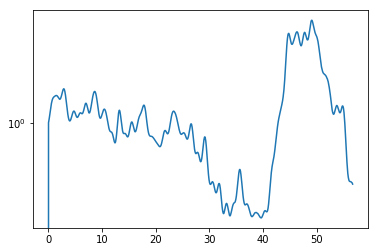

In [52]:
plt.semilogy(tn, np.abs(en_tot - en_tot[0])/en_tot[0])
#plt.xlim((0., 20.))

In [53]:
en_tot

array([ 1.69017955e+02,  1.57082169e-10, -3.75983562e-04, ...,
        1.58381541e-02,  1.59769515e-02,  1.61814896e-02])

Text(0,0.5,'$\\epsilon_B$')

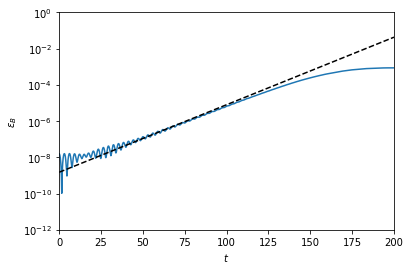

In [32]:
plt.semilogy(tn, en_B)
#plt.semilogy(tn, en_U)
#plt.xlim((0., 200.))
#plt.ylim((1e-7, 1e-3))
#plt.semilogy(tn, 1e-5*np.exp(2*0.04*tn), 'k--')
plt.xlim((0., 200.))
plt.ylim((1e-12, 1e0))
plt.semilogy(tn, 1.5e-9*np.exp(2*tn*0.042898729582425695), 'k--')
plt.xlabel('$t$')
plt.ylabel('$\epsilon_B$')